# **Fooling AI image classifers**
#### by Outmani Ossama

hello


# A. Introduction

## 1. Getting used with the model

In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###  1.a. load the model

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,weights='imagenet')
pretrained_model.trainable = False

# function to get the predicted label
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

###  1.b. get the image

In [ ]:
# comment this cell if you are runnning this notebook locally
from google.colab import files

def read_image(image_path=None):
  if image_path is None:
    uploaded = files.upload()
    image_path=list(uploaded.keys())[0]
  image_raw = tf.io.read_file(image_path)
  image = tf.image.decode_image(image_raw)
  return image


In [ ]:
# comment this cell if you are runnning this notebook in Collab
# def read_image(image_path=None):
#   if image_path is None:
#     image_path=input("Please enter the image path")
#   image_raw = tf.io.read_file(image_path)
#   image = tf.image.decode_image(image_raw)
#   return image

In [ ]:
# default image
image = read_image(image_path="/content/drive/MyDrive/Adversarial_exemples/Cat_image.jpg")

# to upload your own image
# image = read_image()

###  1.c. Preprocess the image

In [ ]:
#used only to preprocess the original image
def preprocess_org(photo):
  resized_image=tf.image.resize(photo,(224,224))
  resized_image=resized_image[None,...]
  return resized_image

In [ ]:
#preprecess the image to be compatible with the model
def preprocess(photo):
  resized_image=tf.image.resize(photo,(224,224))
  resized_image=resized_image[None,...]
  preprocessed_image = tf.keras.applications.mobilenet_v2.preprocess_input(resized_image)
  return preprocessed_image

In [ ]:
preprocessed_image=preprocess(image)

###  1.d. Predict the label

In [ ]:
import json

#return one_hot encoding corresponding to given label
def one_hot_from_label(label,size=1000):
  with open("/content/drive/MyDrive/Adversarial_exemples/imageNet.json","r") as f:
    labels_dict=json.load(f)
  index=labels_dict[label]
  label_array = tf.one_hot(index, size)
  label_array = tf.reshape(label_array, (1,size))

  return label_array

In [ ]:
#probilities of each label for the given image
def mobilenet_v2_predict(image):
  preprocessed_image=preprocess(image)
  predictions=pretrained_model.predict(preprocessed_image,verbose="0")
  decoded_prediction=decode_predictions(predictions,top=1)[0]

  loss_object = tf.keras.losses.CategoricalCrossentropy()
  label=decoded_prediction[0][1]
  one_hot_label=one_hot_from_label(label)
  loss = loss_object(one_hot_label, predictions)
  return {"predictions" : predictions ,"loss" : loss}

In [ ]:
# get label and confidence level for an image
def get_class(probabilities):
  _ , label , confidence = decode_predictions(probabilities,top=1)[0][0]
  return {"label":label,"confidence":confidence}

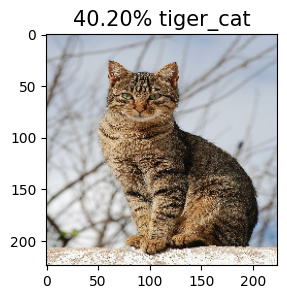

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (3, 3)
mpl.rcParams['axes.grid'] = False

#display given image along with prediction information
def display_prediction(image,xlabel=None):
    plt.figure()
    img_ajusted=np.asarray(preprocess_org(image)).reshape(224,224,3)
    plt.imshow(img_ajusted/255)
    label,confidence=get_class(mobilenet_v2_predict(image)["predictions"]).values()
    plt.title(f"{confidence*100:.2f}% {label}",fontsize="15")
    if xlabel is not None:
        plt.xlabel(xlabel,fontsize="13")

display_prediction(image)

## 2. Building Adversarial exemples

In [ ]:
#generate noise for a given image
def generate_adversarial_noise(image,type="sign"):
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    label=get_class(mobilenet_v2_predict(image)["predictions"])["label"]
    one_hot_label=one_hot_from_label(label)
    image=preprocess(image)
    with tf.GradientTape() as tape:
      tape.watch(image)
      predictions = pretrained_model(image)
      loss = loss_object(one_hot_label, predictions)
    gradient = tape.gradient(loss, image)    # Get the gradients of the loss with respect to the input image.

    if type=="sign":
      signed_grad = tf.sign(gradient)  # Get the sign of the gradients to create the perturbation

      return signed_grad
    elif type=="max":
      max_grad = tf.reduce_max(tf.math.abs(gradient)) # Get the normalize version of the gradients to create the perturbation

      return gradient/max_grad

## 3. Visualising

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False

#display before and after and noise of a given image after FGSM
def display_exemples(image,epsilon=[0.07],type="sign"):
  i=1
  for e in epsilon :
    plt.figure(i)
    plt.subplot(231)
    noise=generate_adversarial_noise(image,type=type)
    img_ajusted=np.asarray(preprocess_org(image)).reshape(224,224,3)
    plt.imshow(img_ajusted/255)
    prediction=mobilenet_v2_predict(image)
    label,confidence=get_class(mobilenet_v2_predict(image)["predictions"]).values()
    plt.title(f"{confidence*100:.2f}% {label}")
    label=get_class(mobilenet_v2_predict(image)["predictions"])["label"]


    plt.subplot(233)
    adv_image=preprocess_org(image)+e*noise
    adv_image=tf.clip_by_value(adv_image,0,255)
    prediction_couple=mobilenet_v2_predict(tf.reshape(adv_image,(224,224,3)))["predictions"]
    label,confidence=get_class(prediction_couple).values()
    plt.title(f"{confidence*100:.2f}% {label}")
    adv_ajusted=tf.reshape(adv_image,(224,224,3))
    loss_object = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0)
    one_hot_label=one_hot_from_label(label)
    loss = loss_object(one_hot_label, prediction_couple)

    plt.imshow(adv_ajusted/tf.reduce_max(tf.math.abs(adv_ajusted)))

    plt.subplot(232)
    plt.title(f"x {e}")
    plt.xlabel(f"type : {type} , loss : {loss}")

    plt.imshow(np.asarray(noise*0.5+0.5).reshape(224,224,3))

    i+=1


display_exemples(image,[0.07,1,10],"sign")

# B. Paper Experiments

In [ ]:
img=read_image()

## Experiment 1 : FGSM

applying FGSM to an image

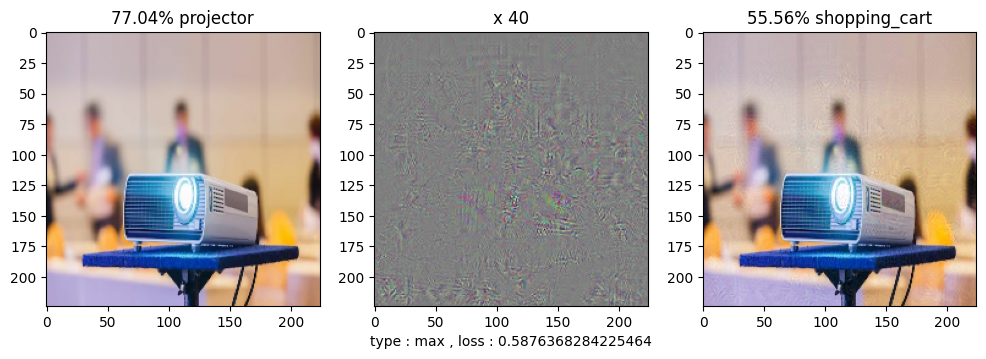

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False
display_exemples(img,[40],"max")

## Experiment 2 : FGSM with multiple epsilons

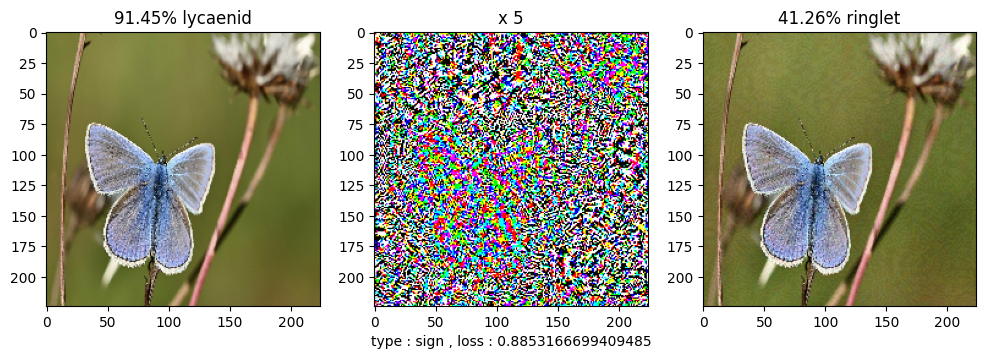

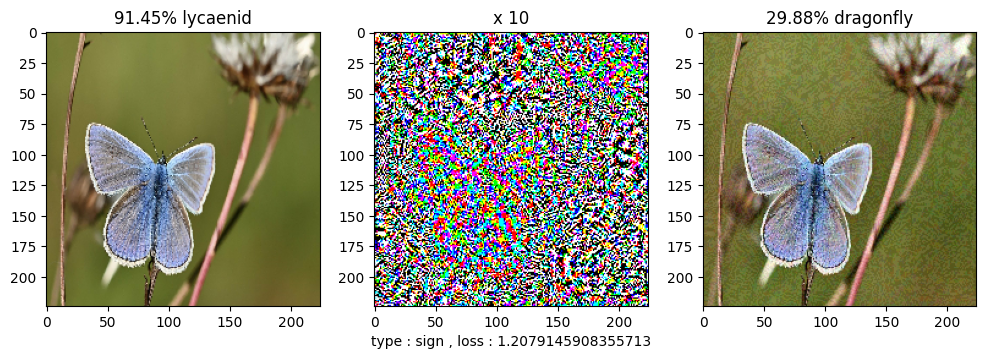

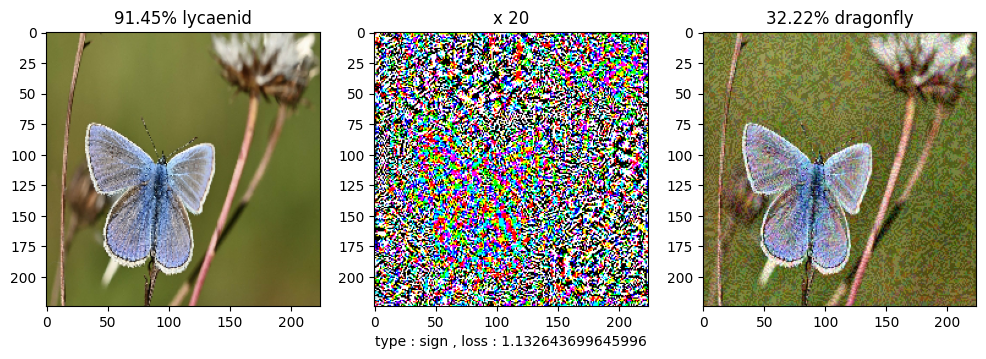

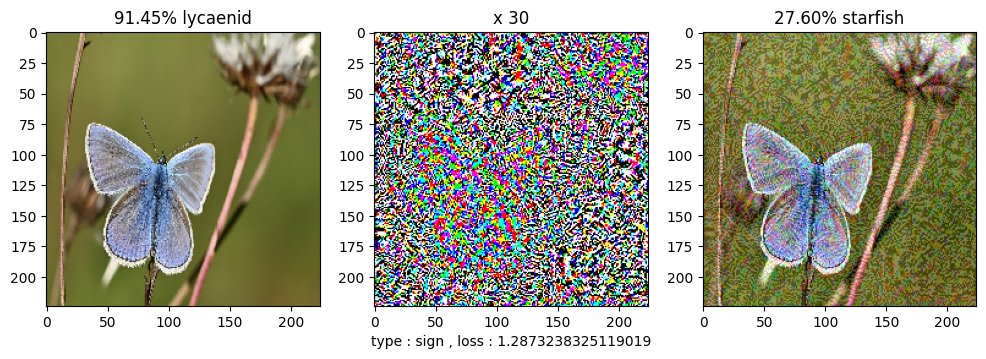

In [ ]:
display_exemples(img,[5,10,20,30],"sign")

## Experiment 3 : optimizing FGSM

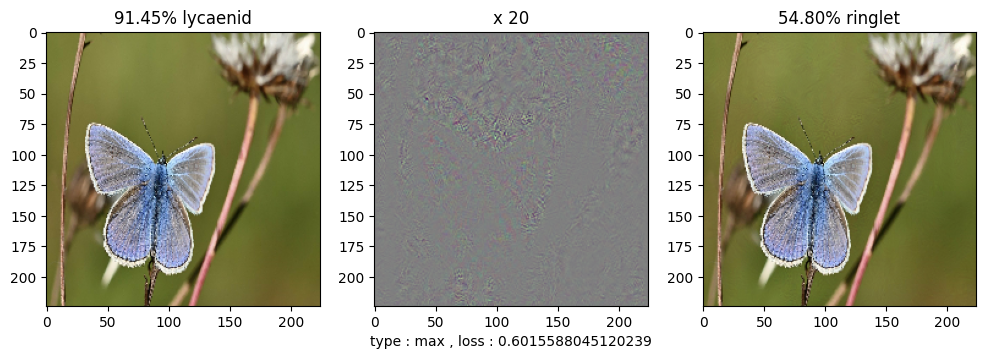

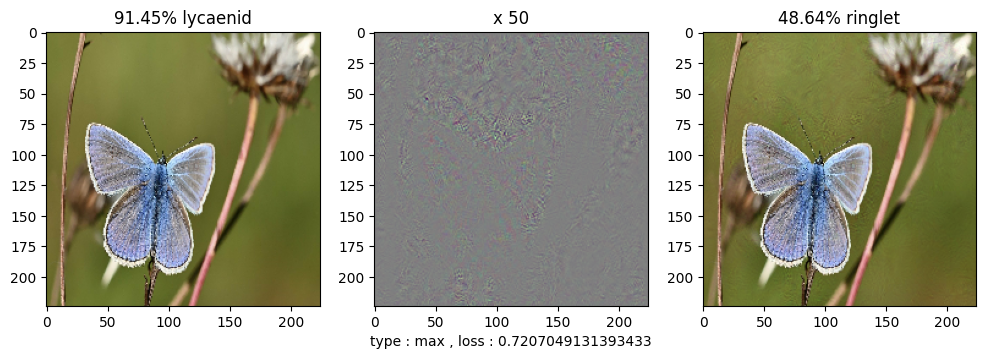

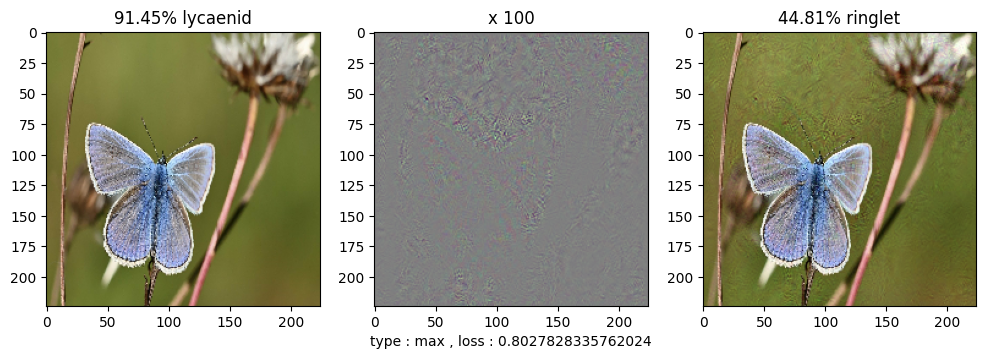

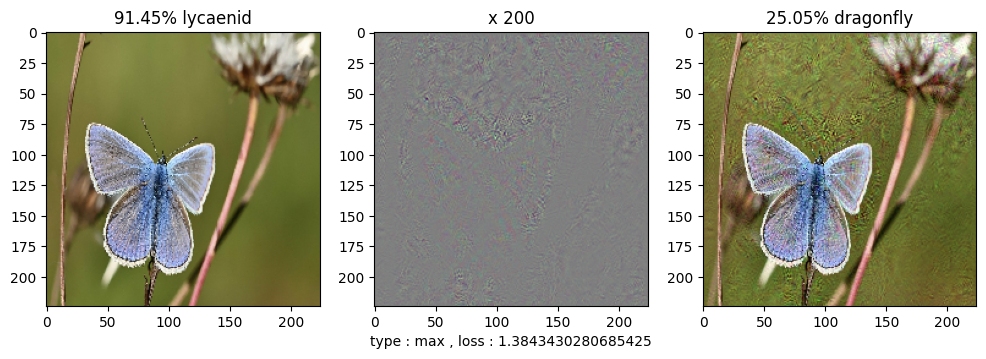

In [ ]:
display_exemples(img,[20,50,100,200],"max")

## Experiment 5 : limiting the noise effect

In [ ]:
image=read_image()

Saving common-blue-8285440_1280.jpg to common-blue-8285440_1280.jpg


In [ ]:
noise=generate_adversarial_noise(image,"max")

In [ ]:
import tensorflow as tf

# Assuming generate_adversarial_noise(image, "max") generates a tensor with shape (1, 224, 224, 3)
tensor = generate_adversarial_noise(image, "max")
tensor = tf.reshape(tensor, (224, 224, 3))


import tensorflow as tf

def keep_top_values(tensor, top_k):
    # Flatten the tensor
    flat_tensor = tf.reshape(tensor, [-1])

    # Get the values of the top_k absolute values
    top_values, top_indices = tf.math.top_k(tf.math.abs(flat_tensor), top_k)

    # Create a mask of zeros with the same shape as flat_tensor
    mask = tf.scatter_nd(tf.expand_dims(top_indices, axis=1), tf.ones_like(top_indices, dtype=tensor.dtype), flat_tensor.shape)

    # Reshape the mask to have the same shape as the original tensor
    mask = tf.reshape(mask, tensor.shape)

    # Multiply the original tensor by the mask
    result = tensor * mask

    return result

result = keep_top_values(tensor, 20)
result

NameError: name 'generate_adversarial_noise' is not defined

In [ ]:
tf.reduce_max(masked_tensor)

<tf.Tensor: shape=(), dtype=float32, numpy=-5.7031148e-06>

In [ ]:
tf.reduce_max(tensor)

<tf.Tensor: shape=(), dtype=float32, numpy=0.78085333>

In [ ]:
closest_to_zero_indices

<tf.Tensor: shape=(150528,), dtype=int32, numpy=array([  2118, 110082, 127571, ...,  46078,  36418,  58090], dtype=int32)>